In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import itertools
import anndata as an
import scanpy.external as sce
import scipy
import scipy.sparse as sp
import gget
import time
import sklearn
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.manifold import MDS
import sklearn.metrics as sm
from adjustText import adjust_text

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/imputed_adata/hvg13000.h5ad"
adata = sc.read_h5ad(fpath)

# make counts out of 10000
scale_expression  = 1e4
adata.layers['scaled_scanvi'] = np.log1p(adata.layers['scanvi_counts'] * scale_expression)

sc.logging.print_memory_usage()
print(adata)

Memory usage: current 9.23 GB, difference +9.23 GB
AnnData object with n_obs × n_vars = 61115 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'


# filtering 

In [3]:
mask = (adata.obs['dataset'] != 'pellin')
adata = adata[mask, :].copy()

mask = (adata.obs['dataset'] != 'tabula_sapiens')
adata = adata[mask, :].copy()

adata

AnnData object with n_obs × n_vars = 33748 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'

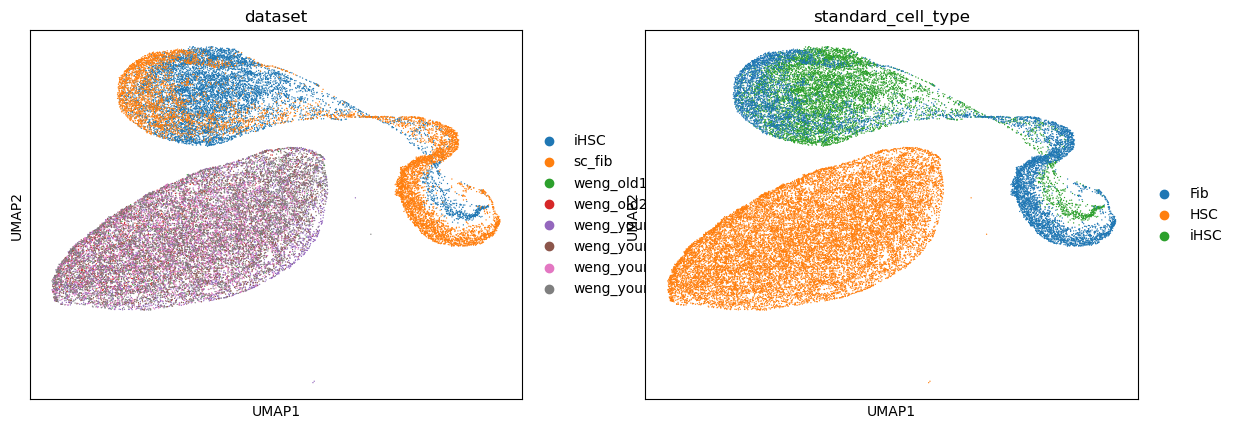

In [4]:
sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ]
)

# Anntotate

In [5]:
# load the obs annotations
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/obs/merged_scfib_obs.csv"
obs = pd.read_csv(fpath)

obs['new_cluster_str'] = obs['new_cluster'].apply(lambda x: f"F{int(x) + 1}")

cluster_map = dict(zip(obs['cell_id'].values, obs['cluster_str'].values))
new_cluster_map = dict(zip(obs['cell_id'].values, obs['new_cluster_str'].values))

adata.obs['cluster_str'] = adata.obs.index.map(cluster_map)
adata.obs['new_cluster_str'] = adata.obs.index.map(new_cluster_map)

# Filter cluster C6
mask = (adata.obs['cluster_str'] == 'C6') & (adata.obs['dataset'] == 'iHSC')
adata = adata[~mask, :].copy()

# filter out low-quality FB clusters
mask = (adata.obs['new_cluster_str'].isin(['F7', 'F8'])) & (adata.obs['dataset'].isin(['iHSC', 'sc_fib']))
adata = adata[~mask, :].copy()

print(adata)
print()
adata.obs['cluster_str'].value_counts()

AnnData object with n_obs × n_vars = 33176 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'cluster_str', 'new_cluster_str'
    uns: 'neighbors', 'pca', 'umap', 'dataset_colors', 'standard_cell_type_colors'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'



cluster_str
C1    3834
C2    1650
C3    1497
C4     558
C5      20
Name: count, dtype: int64

In [6]:
# establish grouping
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C5']), "iHSC-high", "HSC")
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C1', 'C3']), "iHSC-low", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['cluster_str'] == 'C4', "BJ Fib", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['dataset'] == 'sc_fib', "BJ Fib", adata.obs['group'])

print(adata.obs['group'].value_counts())
print()

adata.obs['group2'] = adata.obs['cluster_str'].copy()
adata.obs['group2'] = np.where(adata.obs['cell_label'] == 'HSC', 'HSC', adata.obs['group2'])
adata.obs['group2'] = np.where(adata.obs['dataset'] == 'sc_fib', 'Bj Fib', adata.obs['group2'])

print(adata.obs['group2'].value_counts())
print()

group
HSC          18302
BJ Fib        7873
iHSC-low      5331
iHSC-high     1670
Name: count, dtype: int64

group2
HSC       18302
Bj Fib     7315
C1         3834
C2         1650
C3         1497
C4          558
C5           20
Name: count, dtype: int64



... storing 'cluster_str' as categorical
... storing 'new_cluster_str' as categorical
... storing 'group' as categorical
... storing 'group2' as categorical


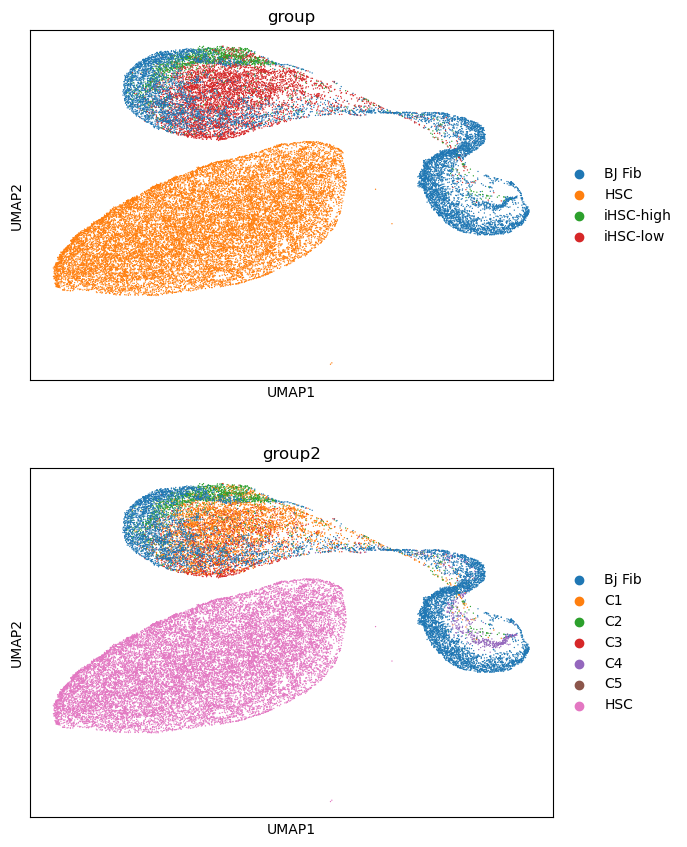

In [7]:
sc.pl.umap(
    adata,
    color=['group', 'group2'],
    ncols=1,
)

# init embedding positions

In [20]:
aggdata = sc.get.aggregate(
    adata,
    by='group2',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean']
df = aggdata.to_df(layer='mean')
df = df.T
df.head()

,Bj Fib,C1,C2,C3,C4,C5,HSC
gene_name,,,,,,,
A1BG,0.817040,1.164085,1.178740,1.164714,0.867740,1.190026,0.285857
A2M,0.365591,0.684429,0.729096,0.690879,0.413548,0.739798,0.413591
A2ML1,1.482582,0.948194,0.906911,0.937663,1.662982,0.862957,0.062655
A3GALT2,0.220516,0.266956,0.271213,0.261943,0.287356,0.266237,0.066727
AACS,0.029266,0.058760,0.065121,0.057499,0.037413,0.064646,0.168479


In [62]:
pdf = df.copy()
metric = 'cosine'

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=pdf.columns,
    columns=pdf.columns,
)

mds = MDS(n_components=5, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape}")

coord_mapper = {}

for i in range(len(pdf.columns)):
    group = pdf.columns[i]
    coords = coordinates[i, :]
    coord_mapper[group] = coords

# build new obsm
X_mds = np.array([coord_mapper[g] for g in adata.obs['group2']])
adata.obsm['X_mds'] = X_mds
print(f"{X_mds.shape=}")
type(X_mds)

(7, 5)
X_mds.shape=(33176, 5)


numpy.ndarray

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


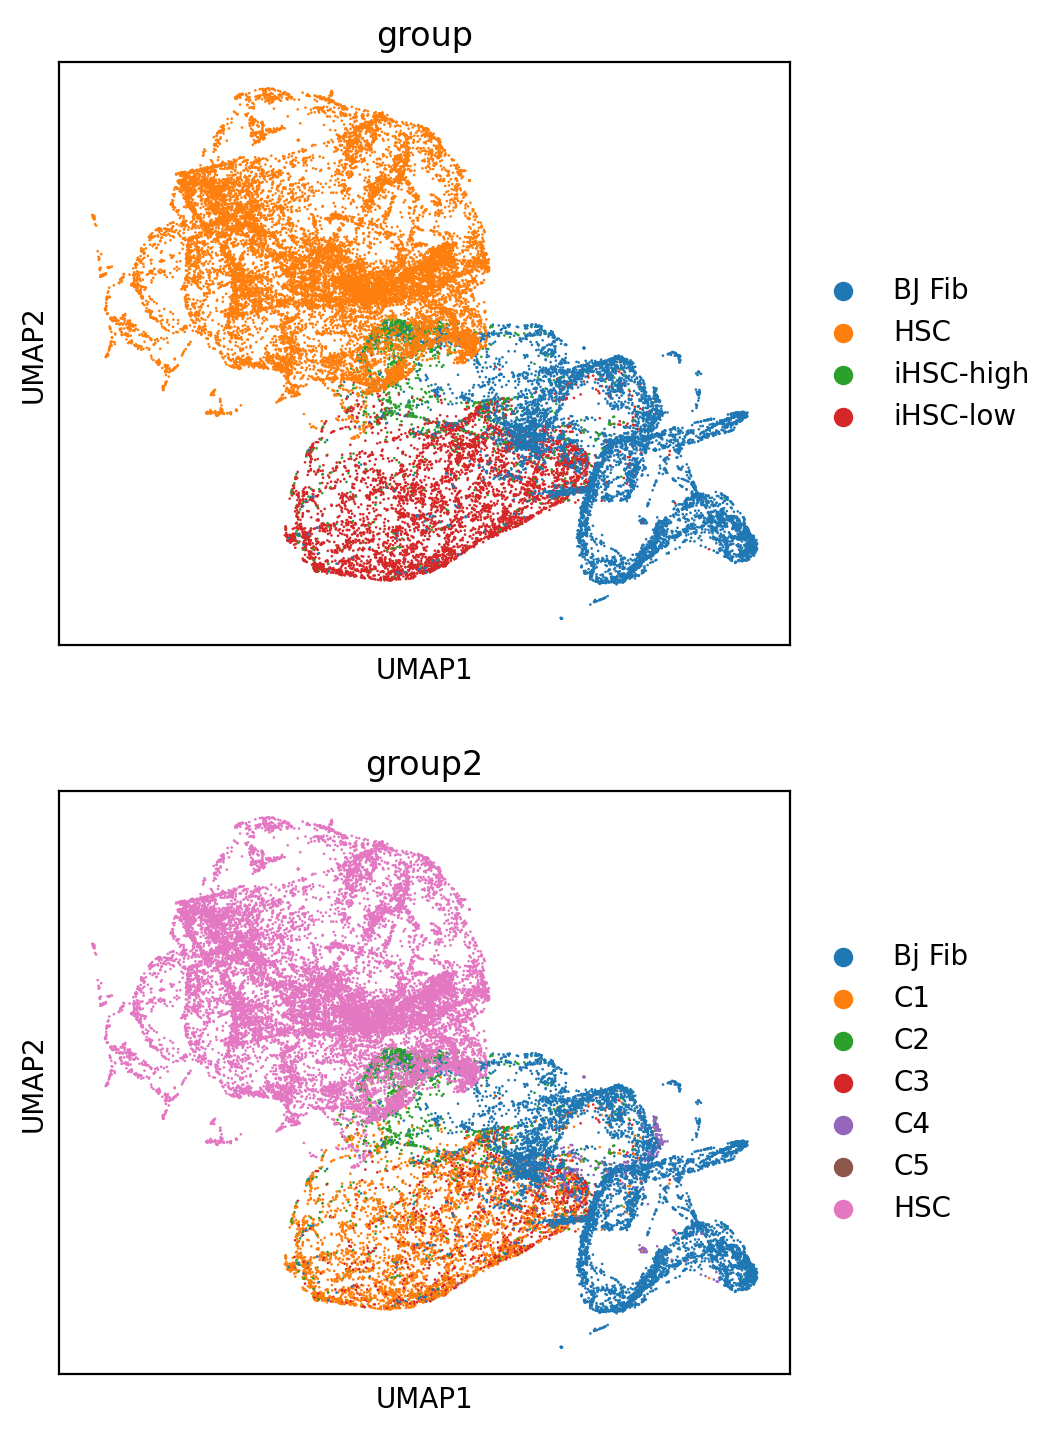

In [92]:
sc.pp.neighbors(
    adata,
    n_neighbors=6,
    use_rep='X_scanvi',   
    # metric='cosine',
)

sc.tl.umap(
    adata, 
    init_pos='X_mds',
    min_dist=0.15,
    spread=5.0, 
)

sc.pl.umap(
    adata,
    color=['group', 'group2'],
    ncols=1,
)

adata.obs['scanvi_UMAP_1'] = adata.obsm['X_umap'][:, 0]
adata.obs['scanvi_UMAP_2'] = adata.obsm['X_umap'][:, 1]

In [ ]:
break

In [9]:
# sc.tl.tsne(
#     adata,
#     use_rep='X_scanvi',
# )

# sc.pl.tsne(
#     adata,
#     color=['group', 'group2'],
#     ncols=1,
# )

In [10]:
# break

(-15.718438863754272,
 23.73209261894226,
 -13.020517539978027,
 24.66190547943115)

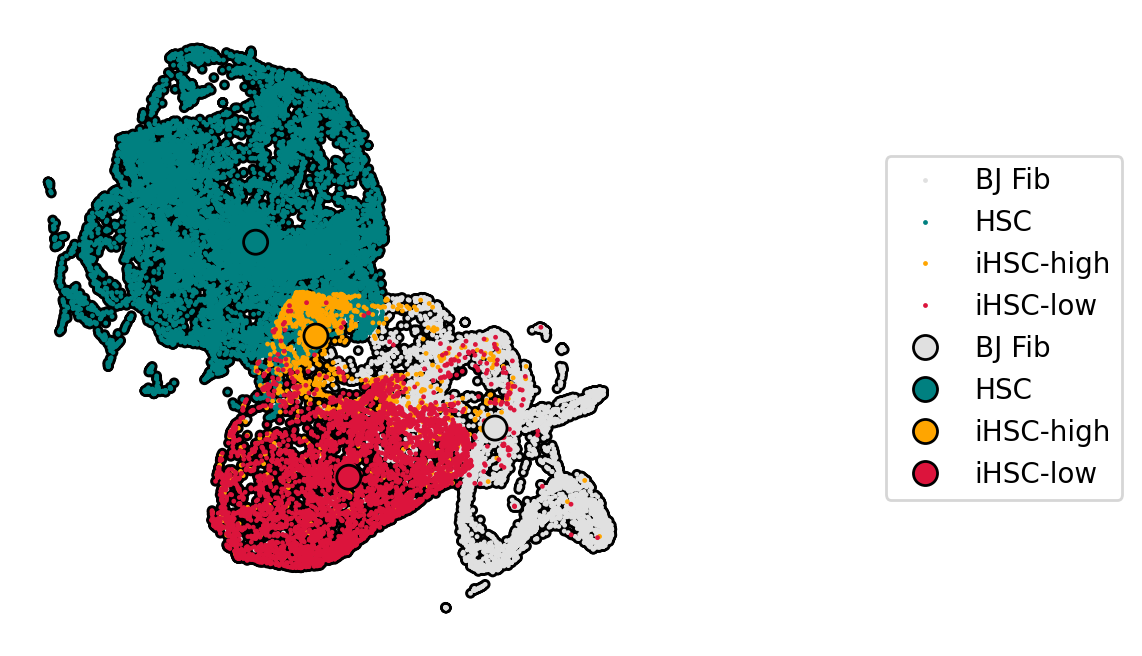

In [97]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

pdf = adata.obs.copy()
pdf = pdf.sort_values(by='group')

colors = [
    '#e0e0e0',    # Brighter light gray
    '#008080',    # Vivid teal
    '#FFA500',    # Bright orange 
    '#DC143C'     # Crimson red
]


sns.scatterplot(
    data=pdf,
    x='scanvi_UMAP_1',
    y='scanvi_UMAP_2',
    c='k',
    ec='none',
    s=15,
    zorder=1,
)

sns.scatterplot(
    data=pdf,
    x='scanvi_UMAP_1',
    y='scanvi_UMAP_2',
    hue='group',
    ec='none',
    palette=colors,
    s=3,
    zorder=2,
)

# Calculate centroids
centroids = pdf.groupby('group').agg(
    {'scanvi_UMAP_1': 'median', 'scanvi_UMAP_2': 'median'}
)

# Plot centroids
sns.scatterplot(
    data=centroids,
    x='scanvi_UMAP_1',
    y='scanvi_UMAP_2',
    hue=centroids.index,  
    palette=colors, 
    s=75,  
    linewidth=1, 
    edgecolor='k',  
    zorder=3, 
)


plt.yticks([])
plt.xticks([])

sns.move_legend(
    plt.gca(),
    loc='center right',
    title="",
    bbox_to_anchor=(1.8, 0.5),
)
plt.axis(False)

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [77]:
def plot_gene_expression(exp_df, pdf, gene, cmap='viridis', vmin=None, vmax=None, ax=None, colorbar=True):
    """
    Plots gene expression on UMAP coordinates with color gradient.

    Args:
        exp_df: DataFrame containing gene expression data.
        pdf: DataFrame containing UMAP coordinates.
        gene: The gene to plot.
    """
    vector = exp_df[gene].values
    sorted_idx = np.argsort(vector)
    if vmax is None:
        vmax = vector.max()
    if vmin is None:
        vmin = vector.min()

    print(f"{vmax=:.5f} {vmin=:.5f}")
    if ax is None:
        fig, ax = plt.subplots()

    # Base scatterplot (black dots)
    sns.scatterplot(
        data=pdf,
        x='scanvi_UMAP_1',
        y='scanvi_UMAP_2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    # Expression-colored scatterplot
    sns.scatterplot(
        data=pdf.iloc[sorted_idx],
        x='scanvi_UMAP_1',
        y='scanvi_UMAP_2',
        ec='none',
        hue=vector[sorted_idx],
        palette=cmap,
        s=8,
        zorder=1,
        hue_norm=(vmin, vmax),
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(gene)
    sns.despine(left=True, bottom=True)


    if colorbar:
        # Create colorbar
        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # This is necessary for the colorbar to work

        # Add colorbar to the plot
        cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.45)
    
    plt.axis('auto')

In [ ]:
# break

==== RUNX1 ====
vmax=3.10866 vmin=0.11391
==== KIT ====
vmax=1.13466 vmin=0.21048
==== CMPK2 ====
vmax=0.16876 vmin=0.05968
==== AFAP1L1 ====
vmax=0.12299 vmin=0.04973
==== FGR ====
vmax=1.11880 vmin=0.08387
==== KLF2 ====
vmax=3.86520 vmin=0.58061


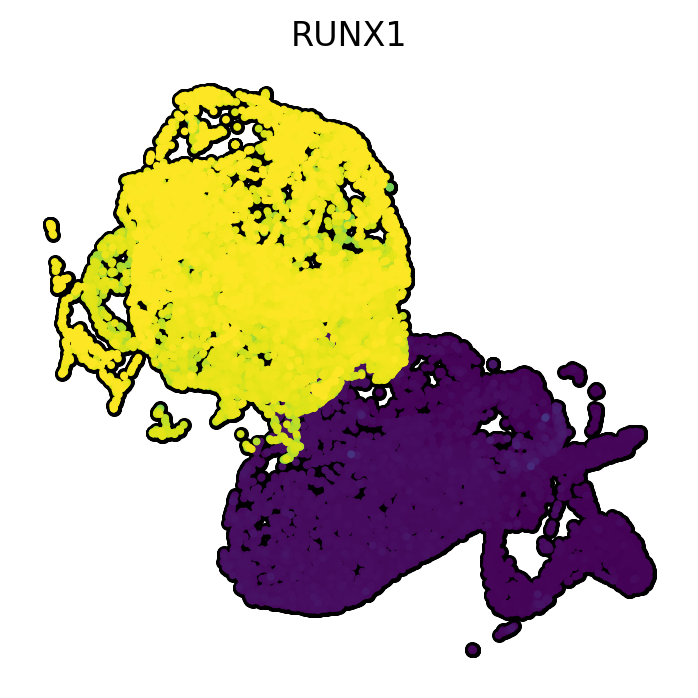

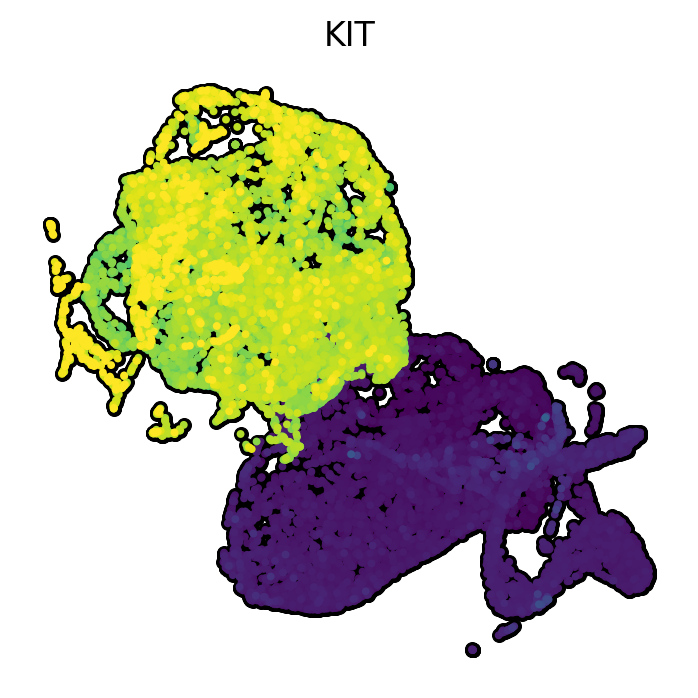

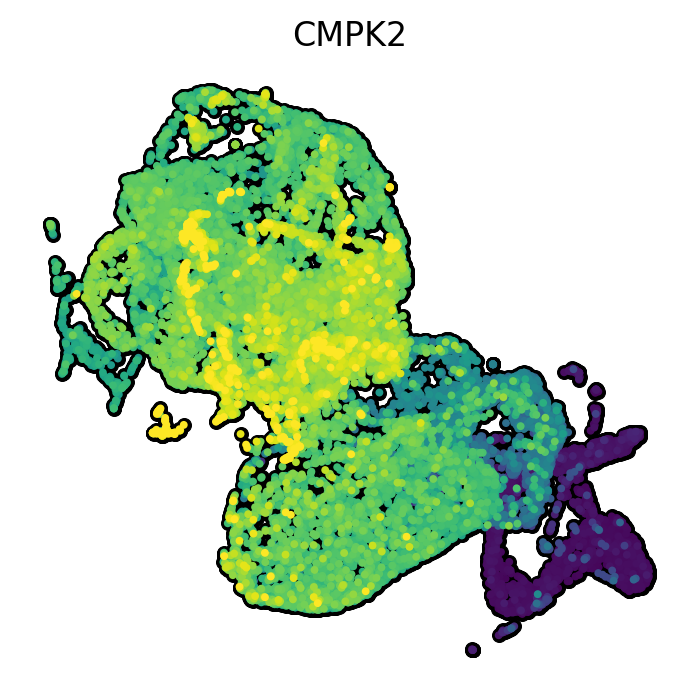

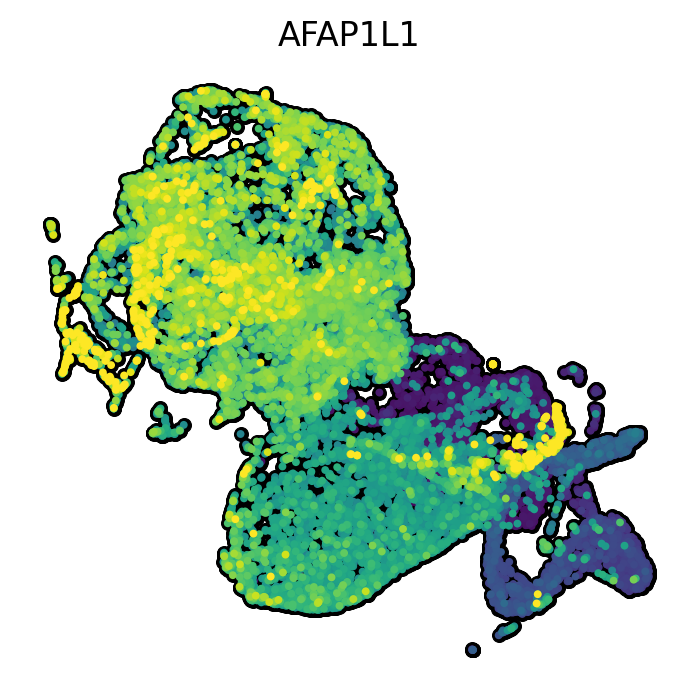

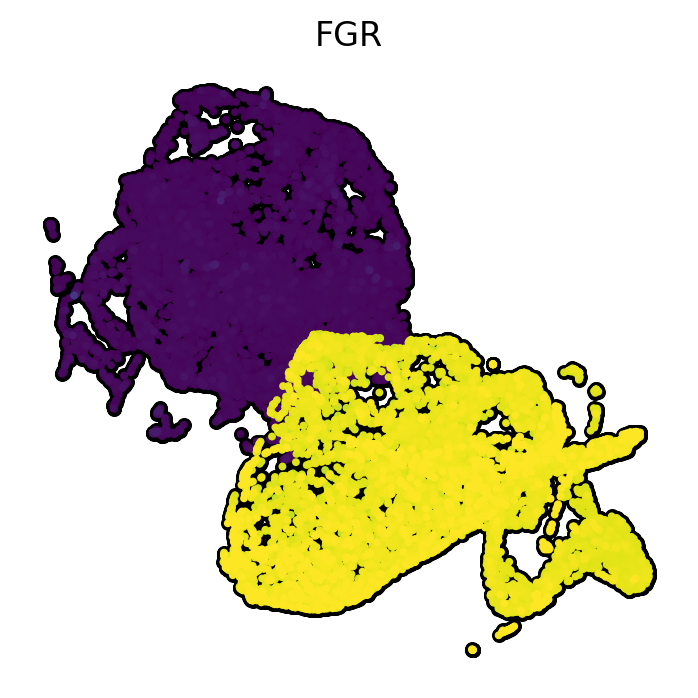

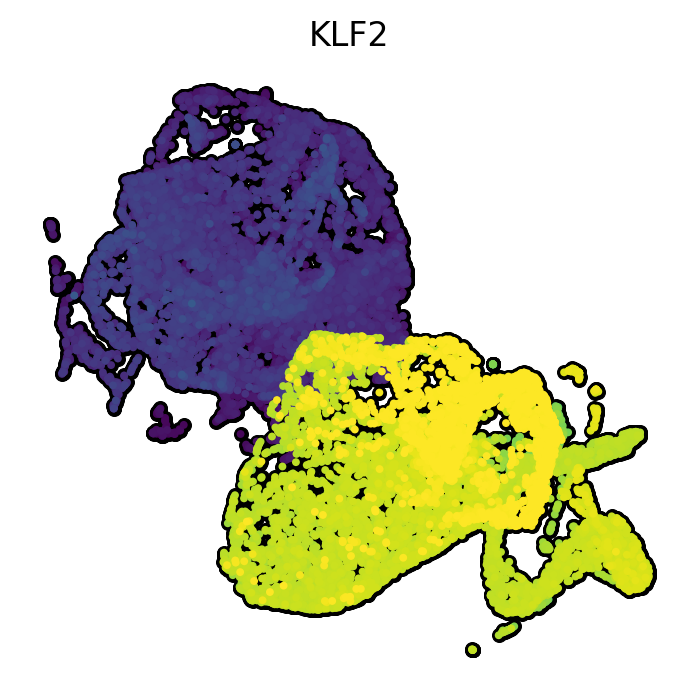

In [90]:
gene_list = [
    'RUNX1',
    'KIT',
    'CMPK2',
    'AFAP1L1',
    'FGR',
    'KLF2',
]

layer = 'scaled_scanvi'

pdf = adata.obs.copy()
exp_df = adata[:, gene_list].to_df(layer=layer)

for gene in gene_list:
    print(f"==== {gene} ====")
    stat = exp_df[gene].describe(percentiles=[0.1, 0.5, 0.53, 0.9, 0.95, 0.99])
    vmax = stat.loc['99%']

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4.25, 4

    plot_gene_expression(
        exp_df, 
        pdf, 
        gene, 
        # vmin=0,
        vmax=vmax,
        # cmap='plasma', 
        cmap='viridis', 
        colorbar=False,
    )

    # break

In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

pathway = 'Hematopoietic Stem Cells'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]
list(np.random.choice(query_genes, 20, replace=False))

In [ ]:
plt2.make_colorbar(tick_labels=['low', 'high'])

In [ ]:
break

# Feature Selection

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pathways = [
    'Hematopoietic Stem Cells',
    'Fibroblasts'
]

for pathway in pathways:
    query_genes = list(features[features[pathway]].index)
    adata.var[pathway] = adata.var.index.isin(query_genes)
    print(f"{pathway} total: {len(query_genes)} found: {adata.var[pathway].sum()}")

adata.var['is_marker'] = adata.var[pathways].any(axis=1)
adata.var['is_marker'].value_counts()

In [ ]:
sc.pp.pca(
    adata,
    mask_var='is_marker',
    # n_comps=5,
    layer='scanvi_counts',
)

sc.pp.neighbors(
    adata,
    # n_neighbors=10,
)


sc.tl.paga(
    adata, 
    groups='group',
)

sc.pl.paga(adata, show=False)

sc.tl.umap(
    adata,
    min_dist=0.15,
)

sc.pl.umap(
    adata,
    color=['group', 'group2', 'dataset'],
)

In [ ]:
break

# paga positions

In [ ]:
adata

In [ ]:
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    use_rep='X_scanvi',   
)

sc.tl.paga(
    adata, 
    groups='group',
)

sc.pl.paga(adata, show=False)

sc.tl.umap(
    adata, 
    min_dist=0.15,
    init_pos='paga',
)

sc.pl.umap(
    adata,
    color=['group', 'group2'],
    ncols=1,
)


In [ ]:
break

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    flavor='seurat_v3',
    layer='counts',
    batch_key='dataset',
)

sc.pp.pca(
    adata,
    mask_var='highly_variable',
)

sc.pp.neighbors(
    adata,
    n_pcs=10,
)

sc.tl.umap(
    adata,
)

sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ]
)

In [ ]:
break

In [ ]:
sc.pl.umap(
    adata,
    color=[
        'standard_cell_type',
    ],
    ncols=1,
)

In [ ]:
# New embedding

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    layer='scaled_scanvi',
    batch_key='dataset',
)

sc.pp.pca(
    adata,
    mask_var='highly_variable',
    layer='scaled_scanvi',
)

sc.pp.neighbors(
    adata,
    n_pcs=2,
)

sc.tl.umap(
    adata,
)

sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ]
)

In [ ]:
break

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    layer='scaled_scanvi',
)

sc.pp.pca(
    adata,
    n_comps=15,
    mask_var='highly_variable',
    layer='scaled_scanvi',
)

sc.pp.neighbors(
    adata,
)

sc.tl.umap(
    adata,
)

sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ]
)